This notebook is used to create the runtime graphs for the BiG-SCAPE v2 paper

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="white")

COLOR_MAP = "colorblind"

sns.color_palette(COLOR_MAP)

COLORS = {
    "bigscape_blue": "#52A3A3",
    "dark_blue": "#0E75BB",
    "orange_i_found_on_bigscape_image": "#F7931E",
    "antismash_red": "#AA0000",
    "bigslice_grey": "#515154",
}

In [44]:
# load data
# bs1 csv: size,sample,start,hmm_scan,hmm_align,distance_calc,cc_gen,total
bigscape_v1_matrix = pd.read_csv("bigscape_v1_matrix.csv")
# bs2 csv: size,sample,start,hmm_scan,hmm_scan_save,hmm_align,hmm_align_save,distance_calc,cc_gen,cc_gen_save,total
bigscape_v2_matrix = pd.read_csv("bigscape_v2_matrix.csv")

# for v2 we want to combine the saving steps with their preceding steps
bigscape_v2_matrix["hmm_scan"] = bigscape_v2_matrix["hmm_scan"] + bigscape_v2_matrix["hmm_scan_save"]
bigscape_v2_matrix["hmm_align"] = bigscape_v2_matrix["hmm_align"] + bigscape_v2_matrix["hmm_align_save"]
bigscape_v2_matrix["cc_gen"] = bigscape_v2_matrix["cc_gen"] + bigscape_v2_matrix["cc_gen_save"]

# then drop the saving columns
bigscape_v2_matrix = bigscape_v2_matrix.drop(columns=["hmm_scan_save", "hmm_align_save", "cc_gen_save"])


# bs2 mode csvs. same sa bs2

bigscape_v2_mode_matrix = pd.read_csv("bigscape_v2_mode_matrix.csv")
# this matrix has the full folder names as samples. they are in the form of output_v2_Amycolatopsis_legacy_1
# cut down to the relevant part
bigscape_v2_mode_matrix["sample"] = bigscape_v2_mode_matrix["sample"].str.split("_").str[3:-1]
bigscape_v2_mode_matrix["sample"] = bigscape_v2_mode_matrix["sample"].str.join("_")

# bigslice csvs, both are: size,sample,start,total
bigslice_v1_matrix = pd.read_csv("bigslice_v1_matrix.csv")
bigslice_v2_matrix = pd.read_csv("bigslice_v2_matrix.csv")

# use size and sample as index
bigscape_v1_matrix = bigscape_v1_matrix.set_index(["size", "sample"])
bigscape_v2_matrix = bigscape_v2_matrix.set_index(["size", "sample"])
# modes runs do not have sample sizes, or at least it's not relevant
bigscape_v2_mode_matrix = bigscape_v2_mode_matrix.set_index(["sample"])

bigslice_v1_matrix = bigslice_v1_matrix.set_index(["size", "sample"])
bigslice_v2_matrix = bigslice_v2_matrix.set_index(["size", "sample"])

# collate totals dataframes
# these are used for the scatter plots
totals = pd.DataFrame(index=bigscape_v2_matrix.index)
totals["BiG-SLICE v1.1"] = bigslice_v1_matrix["total"]
totals["BiG-SLICE v2.0"] = bigslice_v2_matrix["total"]
totals["BiG-SCAPE v1.1"] = bigscape_v1_matrix["total"]
totals["BiG-SCAPE v2.0"] = bigscape_v2_matrix["total"]


totals["size"] = totals.index.get_level_values(0)
# re-add size as a column
totals = totals.melt(value_name="total", var_name="Tool", id_vars="size")

# prepare a similar dataframe for the modes
mode_totals = pd.DataFrame(index=bigscape_v2_mode_matrix.index)
mode_totals["total"] = bigscape_v2_mode_matrix["total"]

# drop irrelevant columns for stacked bar chart
bigscape_v1_matrix_dropped = bigscape_v1_matrix.drop(columns=["start", "total"])
bigscape_v2_matrix_dropped = bigscape_v2_matrix.drop(columns=["start", "total"])

# average out the times on size for relative stacked bar chart
bigscape_v1_matrix_avg = bigscape_v1_matrix_dropped.groupby(["size"]).mean()
bigscape_v2_matrix_avg = bigscape_v2_matrix_dropped.groupby(["size"]).mean()

# calculate proportional time spent on each step
# get the sum of each row
bigscape_v1_matrix_sum = bigscape_v1_matrix_avg.sum(axis=1)
bigscape_v2_matrix_sum = bigscape_v2_matrix_avg.sum(axis=1)
# divide each column by the sum
bigscape_v1_avg_prop = bigscape_v1_matrix_avg.div(bigscape_v1_matrix_sum, axis=0)
bigscape_v2_avg_prop = bigscape_v2_matrix_avg.div(bigscape_v2_matrix_sum, axis=0)

/tmp/ipykernel_42955/2746007607.py:141: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2, 0].legend().remove()


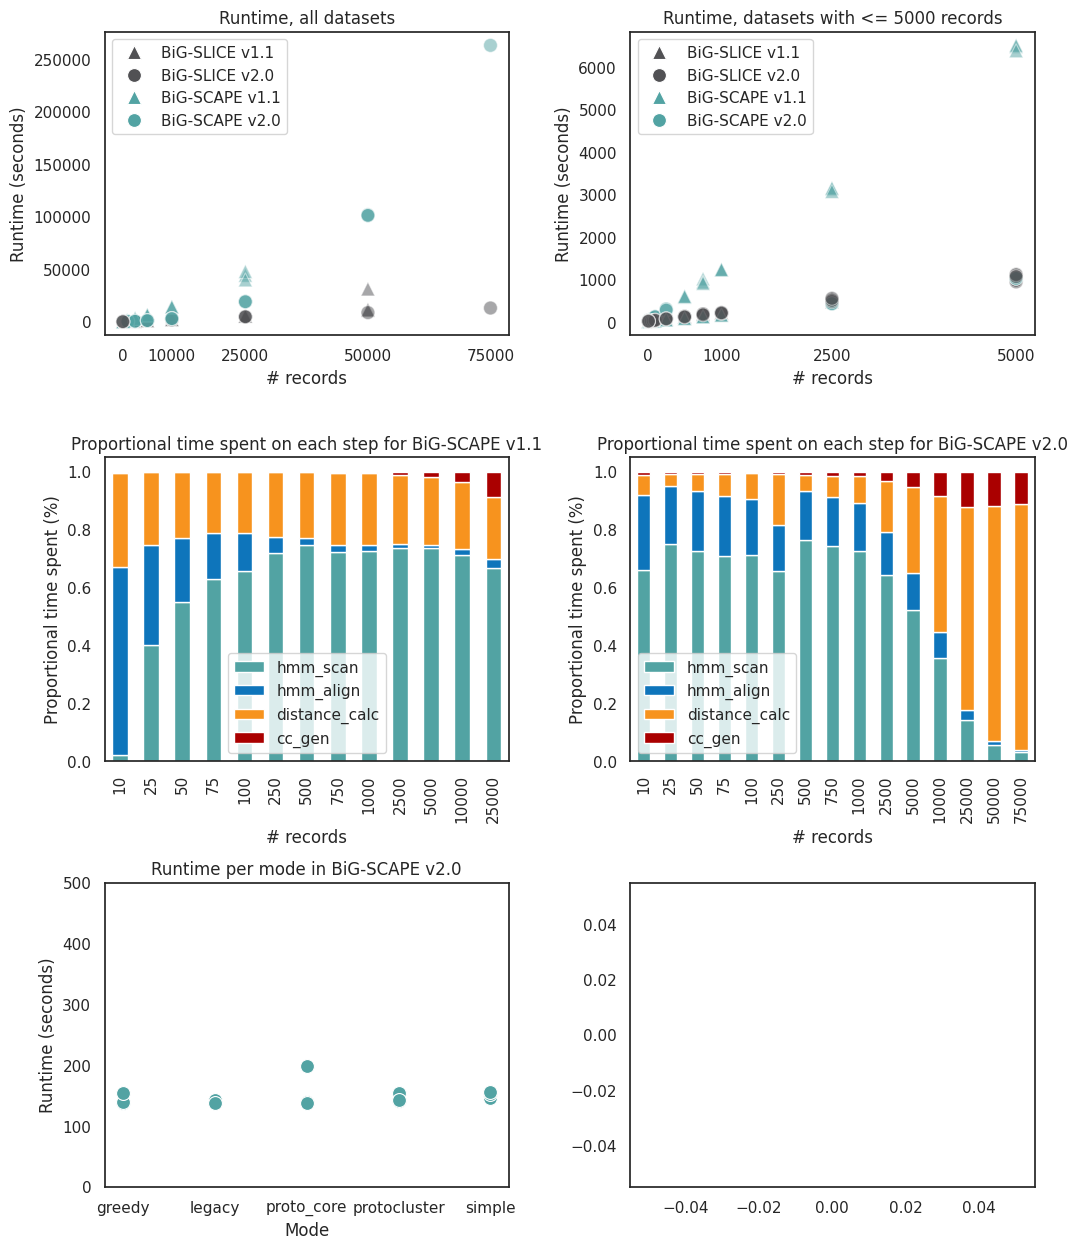

In [45]:
# collate into one image

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
ax = fig.gca()
a = ax.scatter([0],[0], marker='^')
b = ax.scatter([0],[0], marker='o')
triangle_mk, = a.get_paths()
dot_mk, = b.get_paths()
a.remove()
b.remove()

### total runtimes

totals_colors = [
    COLORS["bigslice_grey"],
    COLORS["bigslice_grey"],
    COLORS["bigscape_blue"],
    COLORS["bigscape_blue"],
]
## a) total runtimes for all sample sizes
sns.scatterplot(
    ax=axes[0,0],
    data=totals,
    x="size",
    y="total",
    hue="Tool",
    s=100,
    palette=totals_colors
)

# title
axes[0, 0].set_title("Runtime, all datasets")

# x axis options
axes[0, 0].set_xlabel("# records")
axes[0, 0].set_xticks([0, 10000, 25000, 50000, 75000])

# y axis options
axes[0, 0].set_ylabel("Runtime (seconds)")


# apply correct markers
colls = axes[0, 0].collections
for collection in colls:
    collection.set_paths([triangle_mk] * 42 + [dot_mk] * 42 + [triangle_mk] * 42 + [dot_mk] * 42)
    collection.set_alpha(0.5)

handles, labels = axes[0, 0].get_legend_handles_labels()
handles[0].set_marker("^")
handles[2].set_marker("^")
axes[0, 0].legend(handles, labels)

## b) total runtimes for sample sizes <= 10000
# generate plot
sns.scatterplot(
    ax=axes[0,1],
    data=totals[totals["size"] <= 5000],
    x="size",
    y="total",
    hue="Tool",
    s=100,
    palette=totals_colors
)

# title
axes[0, 1].set_title("Runtime, datasets with <= 5000 records")

# x axis options
axes[0, 1].set_xlabel("# records")
axes[0, 1].set_xticks([0, 1000, 2500, 5000])

# y axis options
axes[0, 1].set_ylabel("Runtime (seconds)")


# apply correct markers
colls = axes[0, 1].collections
for collection in colls:
    collection.set_paths([triangle_mk] * 42 + [dot_mk] * 42 + [triangle_mk] * 42 + [dot_mk] * 42)
    collection.set_alpha(0.5)

handles, labels = axes[0, 1].get_legend_handles_labels()
handles[0].set_marker("^")
handles[2].set_marker("^")
axes[0, 1].legend(handles, labels)

### runtime proportional time spent

## c) proportional time spent on each step for v1
# generate plot
v1_prop_time_colors = [
    COLORS["bigscape_blue"],
    COLORS["dark_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"]
]
bigscape_v1_avg_prop.plot(ax=axes[1, 0], kind='bar', stacked=True, color=v1_prop_time_colors)

# title
axes[1, 0].set_title("Proportional time spent on each step for BiG-SCAPE v1.1")

# x axis options
axes[1, 0].set_xlabel("# records")

# y axis options
axes[1, 0].set_ylabel("Proportional time spent (%)")

## d) proportional time spent on each step for v2
# generate plot
v2_prop_time_colors = [
    COLORS["bigscape_blue"],
    COLORS["dark_blue"],
    COLORS["orange_i_found_on_bigscape_image"],
    COLORS["antismash_red"],
]
bigscape_v2_avg_prop.plot(ax=axes[1, 1], kind='bar', stacked=True, color=v2_prop_time_colors)

# title
axes[1, 1].set_title("Proportional time spent on each step for BiG-SCAPE v2.0")

# x axis options
axes[1, 1].set_xlabel("# records")

# y axis options
axes[1, 1].set_ylabel("Proportional time spent (%)")


### runtime per mode
sns.scatterplot(
    ax=axes[2, 0],
    data=mode_totals,
    x=mode_totals.index,
    y="total",
    s=100,
    color=COLORS["bigscape_blue"]
)
axes[2, 0].set_title("Runtime per mode in BiG-SCAPE v2.0")
axes[2, 0].set_xlabel("Mode")
axes[2, 0].set_ylabel("Runtime (seconds)")
axes[2, 0].set_ylim(0, 500)
axes[2, 0].legend().remove()

# increase margins
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)